Video was given from https://motchallenge.net/vis/MOT16-04

In [30]:
# !pip install distinctipy==1.2.2 filterpy==1.4.5 lap==0.4.0 -q

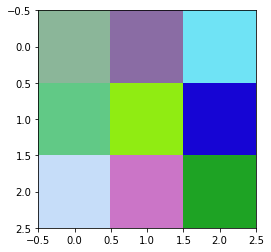

In [1]:
import torch
import cv2
import numpy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sort import Sort
import distinctipy

sample_img = np.random.rand(3,3,3)
plt.imshow(sample_img)

In [2]:
device = 'cuda:0'

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to(device)
model.float()
model.eval()
1

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-22 Python-3.8.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1

In [5]:
from pathlib import Path

data_dir = Path('data')

reference_vid = data_dir / 'ref_vid.mp4'

save_to = data_dir / 'results' / reference_vid.stem
save_to.mkdir(exist_ok=True, parents=True)

In [6]:
mot_tracker = Sort()

In [94]:
! rm -rf data/results/ref_vid/*

In [8]:
file = str(reference_vid)
verbose = True

capture = cv2.VideoCapture(file)
fps = capture.get(cv2.CAP_PROP_FPS)
n_frames = capture.get(cv2.CAP_PROP_FRAME_COUNT)

def color_t(idx):
    state = np.random.get_state()
    numpy.random.seed(seed=idx)
    val = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
    np.random.set_state(state)
    return val

bbs_ids_frame_count = {}

frames = []


pb = np.arange(n_frames)
if verbose:
    pb = tqdm(pb)

for i in pb:
    success, image_cv = capture.read()
    
    if not success:
        break

    preds = model(image_cv)
    detections = preds.pred[0].cpu().numpy()
    track_bbs_ids = mot_tracker.update(detections).tolist()
    
    for j in range(len(track_bbs_ids)):
        coords = track_bbs_ids[j]
        x1, y1, x2, y2 = int(coords[0]), int(coords[1]), int(coords[2]), int(coords[3])
        
        name_idx = int(coords[4])
        
        if name_idx in bbs_ids_frame_count.keys():
            bbs_ids_frame_count[name_idx] += 1
        else:
            bbs_ids_frame_count[name_idx] = 1
            
        sec_per_id = bbs_ids_frame_count[name_idx] / fps
            
        name = f"ID:{name_idx}|T:{sec_per_id:.2f}s"
        color = color_t(name_idx)
        
        cv2.rectangle(image_cv, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image_cv, name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        cv2.imwrite(str(save_to / f"{int(i)}.png"), image_cv)
        # plt.imshow(image_cv)
        # plt.show()
        
    # if i % frame_read_freq == 0:
    #     frame = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
    #     frame = torch.tensor(frame/255, dtype=torch.float32)
    #     frames.append(frame.permute(2,0,1)[None])

  1%|█                                                                                                | 11/1050 [00:00<00:31, 33.21it/s]


# Save video

In [1]:
# !pip install moviepy --upgrade
!pip install ffmpeg --upgrade

  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=57595be41ab9ccad664819feec455f44f7fb8c656bc08b27190be3fa0fc843d0
  Stored in directory: /root/.cache/pip/wheels/30/33/46/5ab7eca55b9490dddbf3441c68a29535996270ef1ce8b9b6d7
Successfully built ffmpeg


In [24]:
import cv2
import os

image_folder = str(save_to)
video_name = 'video.mp4'
fps = 30

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
sorted_img_ids = sorted([int(i.split('.')[0]) for i in images])
images = [f"{i}.png" for i in sorted_img_ids]

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
video = cv2.VideoWriter(video_name, fourcc, fps, (width,height))

for image in tqdm(images):
    video.write(cv2.imread(os.path.join(image_folder, image)))

video.release()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:17<00:00, 61.73it/s]
